<a href="https://colab.research.google.com/github/spsagar13/Natural-Language-Processing/blob/main/SimpleAudioRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

speech_commands dataset, detect a single word spoken, from a set of ten target words.
Portion of 105,000 WAV audio files of people saying different words.

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file('mini_speech_commands.zip',
                          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
                          extract = True,
                          cache_dir='.',
                          cache_subdir='data'
                          )

182083584/182082353 [==============================] - 1s 0us/step


Checking the downloaded dataset

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['stop' 'right' 'down' 'go' 'left' 'yes' 'up' 'no']


Extracting audio files into a list and shuffling it

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Numer of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Numer of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/yes/2296b1af_nohash_1.wav', shape=(), dtype=string)


splitting dataset to training, validation and testing
80:10:10

In [6]:
train_files = filenames[:6400]
val_files = filenames[6400:6400+800]
test_files = filenames[-800:]

print('Training size:', len(train_files))
print("Val size:", len(val_files))
print("test size", len(test_files))

Training size: 6400
Val size: 800
test size 800


Reading auio files and their labels

binaryfiles -> tensor, using tf.audio.decode_wav

Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, as in mini_speech_commands, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. tf.audio.decode_wav will normalize the values to the range [-1.0, 1.0].

In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  print(parts)
  # to work in tf graph, using index
  return parts[-2]

wav -> tuple

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
autotune = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=autotune)

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


Chcking some audios and labels

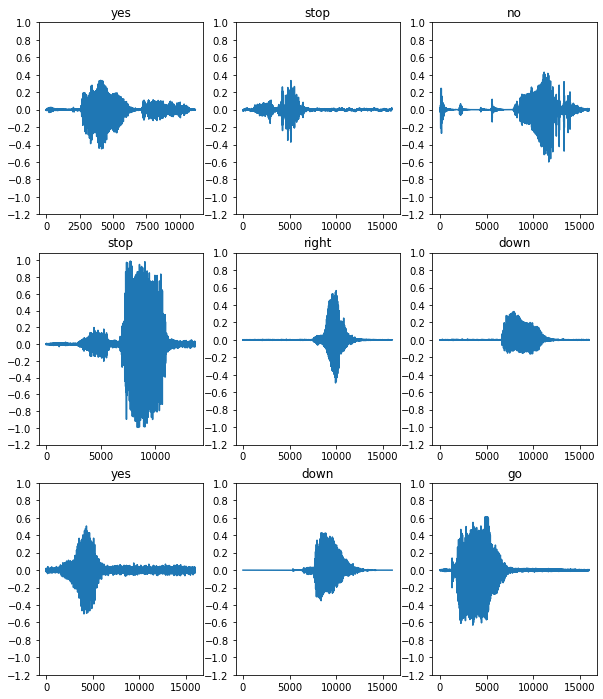

In [11]:
rows, cols = 3,3
n = rows * cols
fig, axes = plt.subplots(rows,cols, figsize=(10,12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols # to get the whole number component
  c = i % cols 

  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2,1.2,0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


converting waveform into a spectrogram using STFT

In [12]:
def get_spectrogram(waveform):
  #padding the files that has less than 16000 samples. 16k
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  #concatenating audio and padding, to make it all same length
  waveform = tf.cast(waveform,tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram) # need only magnitude and not phase

  return spectrogram

comparing the waveform , spectrogram and actual audio of one example

In [13]:
for waveform, label in waveform_ds.take(5):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Ausio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Ausio playback


In [14]:
def plot_spectrogram(spectrogram, ax):
  # Converting frequencies to log scale and transpose so that the time is represented in x axis
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]

  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)

  ax.pcolormesh(X, Y, log_spec)

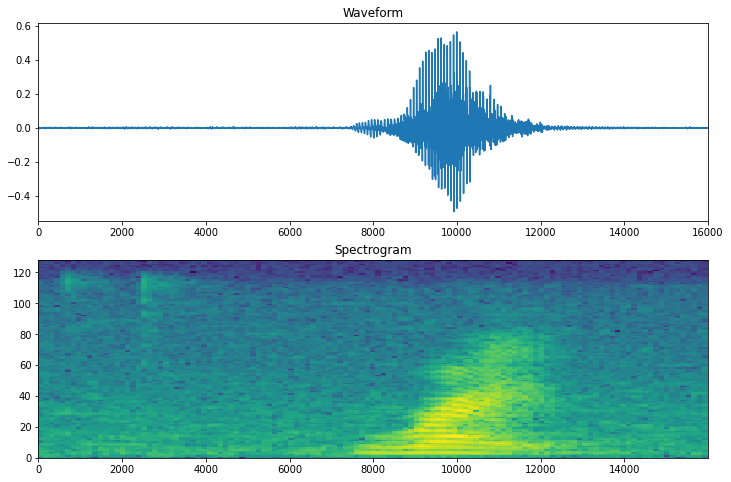

In [15]:
fig, axes = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0,16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Transorming the waveform dataset to have spectrogram images and corresponding labels as integer IDs

In [16]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id


In [17]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=autotune)

examining the spectrogram "images" for different smaple of the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


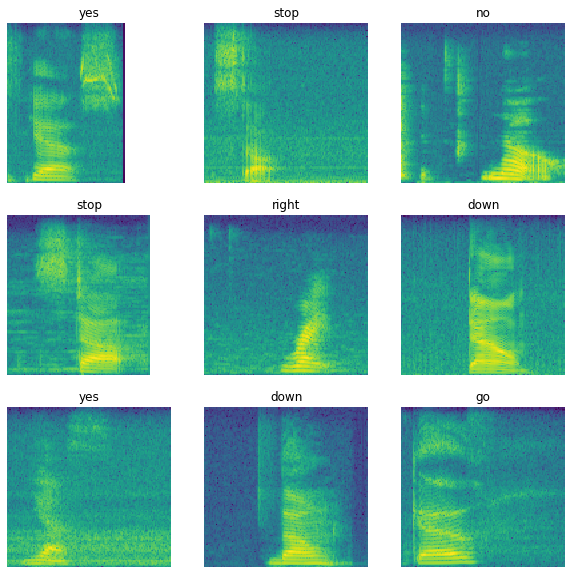

In [18]:
rows = 3
cols = 3
n = rows * cols 
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i//cols 
  c = i% cols 
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

Building and training

In [19]:
# repearing the preprocessing for validation set as well

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=autotune)
  output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=autotune)
  return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
print(train_ds)
print(val_ds)
print(test_ds)

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>
<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>
<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>


In [21]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

print(train_ds)
print(val_ds)

<BatchDataset shapes: ((None, None, 129, 1), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, None, 129, 1), (None,)), types: (tf.float32, tf.int64)>


In [22]:
# Adding cache() and prefetch() operations to reduce read latency while training the model
train_ds = train_ds.cache().prefetch(autotune)
val_ds = val_ds.cache().prefetch(autotune)
print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, None, 129, 1), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, None, 129, 1), (None,)), types: (tf.float32, tf.int64)>


Using CNN, since I converted the audio to spectrogram image.

In [23]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)
print(spectrogram_ds)

Input shape: (124, 129, 1)
8
<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>


In [24]:
# normalization layer is to normalize every pixrl in the image, based on its mean and stantatd deviation
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _:x))

model = models.Sequential([layers.Input(shape=input_shape),
                           preprocessing.Resizing(32,32), # to downsample the input to make training faster
                           norm_layer,

                           layers.Conv2D(32, 3, activation='relu'),
                           layers.Conv2D(64, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Dropout(0.25),
                           
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dropout(0.5),
                           layers.Dense(num_labels)
                           
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [26]:
print(train_ds)

<PrefetchDataset shapes: ((None, None, 129, 1), (None,)), types: (tf.float32, tf.int64)>


In [27]:
epochs = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
                    )

Epoch 1/10
100/100 [==============================] - 47s 147ms/step - loss: 1.9208 - accuracy: 0.2748 - val_loss: 1.3309 - val_accuracy: 0.5763
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 1.2675 - accuracy: 0.5504 - val_loss: 1.0417 - val_accuracy: 0.6675
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.9554 - accuracy: 0.6624 - val_loss: 0.8352 - val_accuracy: 0.7225
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 0.7662 - accuracy: 0.7329 - val_loss: 0.7222 - val_accuracy: 0.7713
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6866 - accuracy: 0.7567 - val_loss: 0.6632 - val_accuracy: 0.7688
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5771 - accuracy: 0.7920 - val_loss: 0.6430 - val_accuracy: 0.7788
Epoch 7/10
100/100 [==============================] - 1s 6ms/step - loss: 0.5316 - accuracy: 0.8068 - val_loss: 0.6079 - val_accuracy: 0.8000
Epo

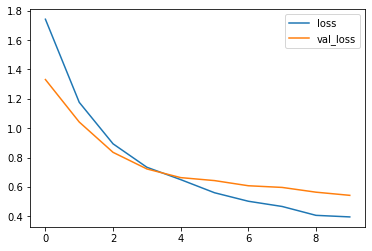

In [29]:
# checking how the model improved
plt.plot(history.epoch, history.history['loss'], history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [31]:
#evaluation test performance

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [36]:
y_predicted = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_predicted == y_true)/len(y_true)
print(f'test accuracy :{test_acc:.0%}')

test accuracy :84%


evaluating the confusion metrics to see how the model did on each of the commnds in the test set

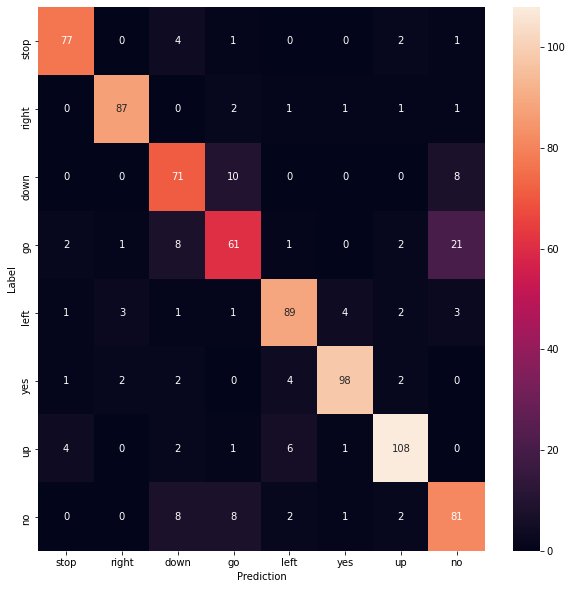

In [37]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_predicted)
plt.figure(figsize=(10,10))

sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [38]:
# verifying the model prediction using input audio file of a person saying NO

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


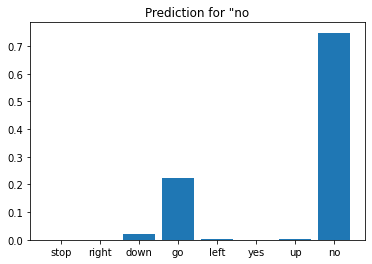

In [41]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Prediction for "{commands[label[0]]}')
  plt.show()